In [2]:
import matplotlib.pyplot as plt
import numpy as np

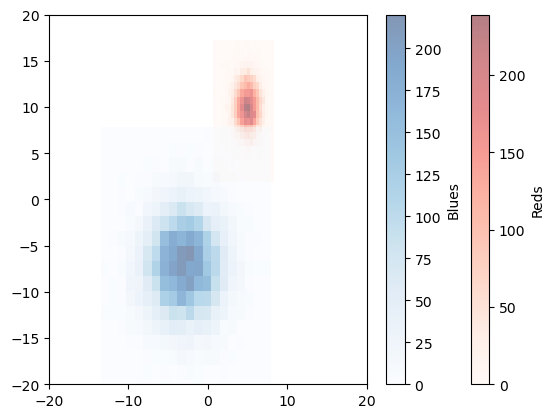

In [14]:

x_data_red = np.random.normal(5, 1, 10000)
y_data_red = np.random.normal(10, 2, 10000)

x_data_blue = np.random.normal(-3, 3, 10000)
y_data_blue = np.random.normal(-7, 4, 10000)

#make 2d histogram
hist_red, xedges_red, yedges_red, image_red = plt.hist2d(x_data_red, y_data_red, bins=[20,20], cmap='Reds',alpha=0.5)
plt.colorbar(image_red, label='Reds')

# make 2d histogram for blue data
hist_blue, xedges_blue, yedges_blue, image_blue = plt.hist2d(x_data_blue, y_data_blue, bins=[20,20], cmap='Blues',alpha=0.5)
plt.colorbar(image_blue, label='Blues')

# set axis limits
plt.xlim(-20, 20)
plt.ylim(-20, 20)

plt.show()
